In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table

import sys
sys.path.append('../')
sys.path.append('../../')

import WD_models
from stark import measure, analyze, plotting, utils

In [128]:
def rv_from_logg(loggarray, teffarray, Hlayer = 'H'):
    mass_sun = 1.9884e30
    radius_sun = 6.957e8
    newton_G = 6.674e-11
    pc_to_m = 3.086775e16
    speed_light = 299792458 #m/s

    font_model = WD_models.load_model('f', 'f', 'f', Hlayer)
    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    logg_teff_to_r = WD_models.interp_xy_z_func(x = font_model['logg'], y = 10**font_model['logteff'],\
                                                z = rsun, interp_type = 'linear')
    
    radius = logg_teff_to_r(loggarray, teffarray) * radius_sun
    rv = (10**loggarray * radius) / (100 * speed_light)
    return rv*1e-3

sdsssample = pd.read_csv('../data/sdss_commonpm.csv').query("snr > 10 and R_chance_align < 0.1")
sdsssample['gravz_H'] = rv_from_logg(sdsssample.loggH, sdsssample.TeffH, Hlayer='H')

sdsssample.dropna(inplace=True)
sdsssample['vstark'] = sdsssample['vgobs'] - sdsssample['vgtheoretical']
sdsssample['e_vstark'] = sdsssample['e_vgobs']

sdss4 = sdsssample.query("wd_rv_from != 'sdss5'").copy()
sdss5 = sdsssample.query("wd_rv_from != 'sdss4'").copy()

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='$T_{eff}$ [$K$]', ylabel='$v_{Stark}$ $[km/s]$'>)

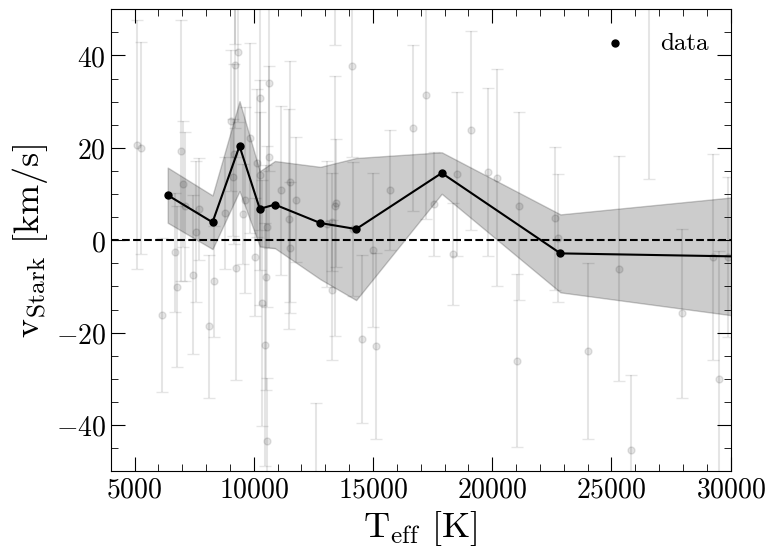

In [129]:
sdssteffdata, sdssloggdata = analyze.calculate_parameter_bins(dataframe=sdss5, teffcol='TeffH', loggcol='loggH', n=10)
sdssalldata = (sdss5.TeffH.values, sdss5.vstark.values, sdss5.e_vstark.values)
plotting.parameter_stark_plot(sdssalldata, paramdata=sdssteffdata, plot_zzceti=False, xlims=(4000, 30000))

(-50.0, 50.0)

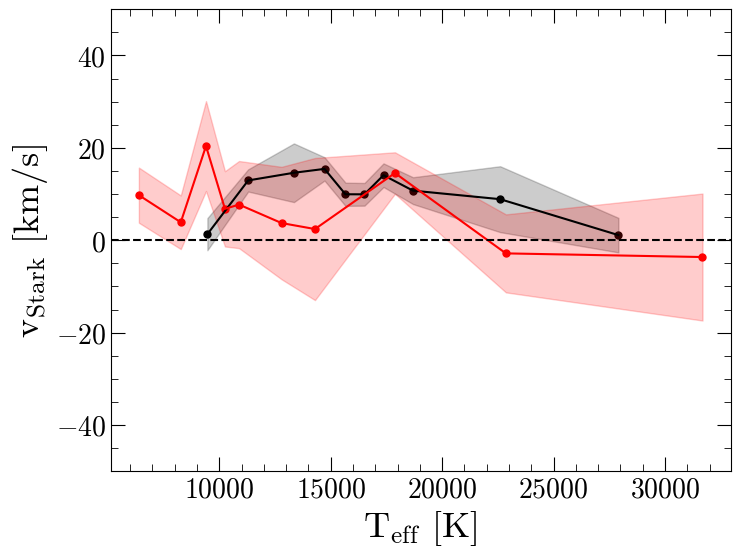

In [130]:
lteargs = {'model' : '1d_da_nlte', 'lines' : 'abgd', 'window' : 8}
spystarkdf = utils.read_stark_effect(lteargs, sigmaclip=False)
spyteffdata, spyloggdata = analyze.calculate_parameter_bins(dataframe=spystarkdf, teffcol='TeffH', loggcol='loggH', n=10)
spyalldata = (spystarkdf.TeffH.values, spystarkdf.vstark.values, spystarkdf.e_vstark.values)

# begin plotting
fig, ax = plt.subplots(ncols = 1, figsize=(8,6))
plotting.plot_with_shaded_error(ax, spyteffdata[0], spyteffdata[1], yerr=spyteffdata[2], 
                                plot_kwargs={'color' : 'k'}, 
                                scatter_kwargs={'label' : 'data', 'color' : 'k', 'marker' : 'o'}, 
                                fill_kwargs={'color' : 'k', 'alpha' : 0.2})
plotting.plot_with_shaded_error(ax, sdssteffdata[0], sdssteffdata[1], yerr=sdssteffdata[2], 
                                plot_kwargs={'color' : 'red'}, 
                                scatter_kwargs={'label' : 'data', 'color' : 'red', 'marker' : 'o'}, 
                                fill_kwargs={'color' : 'red', 'alpha' : 0.2})
#ax.errorbar(teff, stark, yerr=e_stark, **data_kwargs)
ax.axhline(y=0, c='k', ls = '--')
ax.set_ylabel(r'$v_{Stark}$ $[km/s]$')
ax.set_xlabel(r'$T_\text{eff}$ $[K]$')
ax.set_ylim(4000, 30000)
ax.set_ylim(-50, 50)